### Trying to cluster

In [1]:
import functions

import os
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# for statistical tests
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests

In [2]:
rsfMRI_info = pd.read_excel("data/TiMeS_rsfMRI_info.xlsx", engine="openpyxl")  
regression_info = pd.read_excel("data/TiMeS_regression_info_processed.xlsx", engine="openpyxl")
rsfMRI_full_info = pd.read_excel("data/TiMeS_rsfMRI_full_info.xlsx", engine="openpyxl")
print(regression_info.columns)
print(rsfMRI_info)
regression_info=regression_info[['Stroke_location', 'Lesion_side', 'lesion_volume_mm3']]

Index(['subject_full_id', 'TimePoint', 'Behavioral_assessment', 'MRI',
       'Gender', 'Age', 'Education_level', 'Lesion_side_old', 'Lesion_side',
       'Combined', 'Bilateral', 'Comments', 'Stroke_location',
       'lesion_volume_mm3', 'NIHSS', 'FAB_abstraction', 'FAB_flexibility',
       'FAB_programmation', 'FAB_sensitivity_to_interference',
       'FAB_inhibitory_control', 'FAB_environmental_autonomy', 'FAB_TOT',
       'Stroop_color_time', 'Stroop_color_error', 'Stroop_words_time',
       'Stroop_words_error', 'Stroop_interference_time',
       'Stroop_interference_error', 'Stroop_index_WC', 'Stroop_index_InC',
       'Digit_forward_SPAN', 'Digit_forward_TOTAL', 'Digit_backward_SPAN',
       'Digit_backward_TOTAL', 'Digit_sequencing_SPAN',
       'Digit_sequencing_TOTAL', 'Digit_TOTAL',
       'Fugl_Meyer_right_UPPER_EXTREMITY', 'Fugl_Meyer_right_WRIST',
       'Fugl_Meyer_right_HAND', 'Fugl_Meyer_right_COORDINATION_SPEED',
       'Fugl_Meyer_right_TOTAL', 'Fugl_Meyer_left_UPPER

In [3]:
# Folder containing the data
folder_path = "FC_matrices_times_wp11/"

# keep only ROIS
rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 10, 11, 12, 54, 56, 78, 96, 190, 191, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]

t1_matrices, regression_info, rsfMRI_full_info, t1_subjects = functions.load_data(folder_path, rois, type='t1_only')
all_matrices, regression_info, rsfMRI_full_info, all_subjects = functions.load_data(folder_path, rois, type='all')
t1_t3_matched, regression_info, rsfMRI_full_info, t1_t3_subjects = functions.load_data(folder_path, rois, type='t1_t3_matched')
t1_t4_matched, regression_info, rsfMRI_full_info, t1_t4_subjects = functions.load_data(folder_path, rois, type='t1_t4_matched')
t1_t3_matrices, regression_info, rsfMRI_full_info, t1_t3_subjects = functions.load_data(folder_path, rois, type='t1_t3')
t1_t4_matrices, regression_info, rsfMRI_full_info, t1_t4_subjects = functions.load_data(folder_path, rois, type='t1_t4')
#matrices = functions.matrices_to_wide_df(matrices)

Better to keep T1 and T3 as more subjects have these two !
From now on I'll work with matrices

In [4]:
print("matrices column names: ", t1_t3_matrices.columns)

matrices column names:  Index(['subject_id', 'T1_matrix', 'T3_matrix', 'subject_full_id',
       'Lesion_side', 'Stroke_location', 'lesion_volume_mm3', 'Gender', 'Age',
       'Education_level', 'Combined', 'Bilateral'],
      dtype='object')


##### Cluster for all matrices

In [5]:
categorical_cols = ['Lesion_side', 'Stroke_location','Education_level','Combined', 'Bilateral']
numerical_cols = ['lesion_volume_mm3','Age','Gender']

all_matrices_labeled = functions.cluster_and_plot(all_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)
#t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)
#t1_t4_matrices_labeled = functions.cluster_and_plot(t1_t4_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=4, plot=False)

# NORMAL THAT WE GET THE SAME CLUSTERS FOR ALL TIMEPOINTS
# because we are using the same data for clustering (T1)

Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Education_level_2.0',
       'Education_level_3.0', 'Education_level_4.0', 'Education_level_5.0',
       'Education_level_Unknown', 'Combined_Unknown', 'Combined_Yes',
       'Bilateral_Unknown', 'Bilateral_Yes'],
      dtype='object')


/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrices[categorical_cols_name] = matrices[categorical_cols_name].fillna('Unknown')  # Handle missing values


Silhouette score: 0.03914940046153651
Cluster 0: ['s063', 's012', 's015', 's082', 's071', 's003', 's033', 's045', 's042', 's080', 's073', 's086']
Cluster 1: ['s004']
Cluster 2: ['s009', 's030', 's039', 's055', 's046', 's070', 's048', 's076', 's074']
Cluster 3: ['s007', 's031', 's036', 's062', 's065', 's054', 's008', 's037', 's006', 's001', 's052', 's041', 's083', 's049', 's078', 's047', 's040', 's014', 's013', 's025', 's022', 's066', 's059', 's057', 's068', 's050', 's032', 's051', 's060', 's067', 's002', 's005', 's027', 's020', 's016', 's029', 's011', 's017', 's021', 's019', 's072', 's081', 's075']


Index(['Lesion_side_R', 'Lesion_side_R/L', 'Stroke_location_basal ganglia',
       'Stroke_location_cerebellum', 'Stroke_location_cortical',
       'Stroke_location_cortical (insula)',
       'Stroke_location_insula + basal ganglia', 'Stroke_location_mixed',
       'Stroke_location_pons', 'Stroke_location_pons + medulla oblongata',
       'Stroke_location_subcortical',
       'Stroke_location_subcortical (maybe basal ganglia)',
       'Stroke_location_subcortical + basal ganglia', 'Education_level_2.0',
       'Education_level_3.0', 'Education_level_4.0', 'Education_level_5.0',
       'Education_level_Unknown', 'Combined_Unknown', 'Combined_Yes',
       'Bilateral_Unknown', 'Bilateral_Yes'],
      dtype='object')


/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrices[categorical_cols_name] = matrices[categorical_cols_name].fillna('Unknown')  # Handle missing values


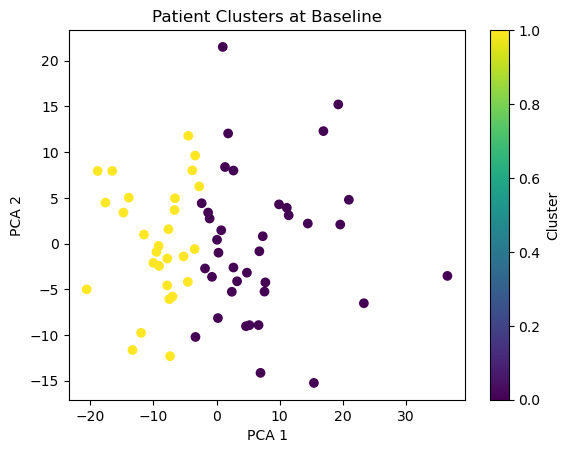

Silhouette score: 0.07789686135710462
Cluster 0: ['s007', 's036', 's062', 's065', 's037', 's039', 's001', 's052', 's063', 's083', 's012', 's015', 's082', 's071', 's047', 's014', 's013', 's025', 's022', 's059', 's068', 's050', 's003', 's060', 's033', 's002', 's029', 's045', 's042', 's080', 's073', 's017', 's021', 's072', 's086', 's081', 's075']
Cluster 1: ['s031', 's009', 's054', 's008', 's030', 's006', 's055', 's041', 's046', 's070', 's048', 's049', 's076', 's078', 's040', 's066', 's057', 's004', 's032', 's051', 's067', 's005', 's027', 's020', 's016', 's011', 's074', 's019']


In [6]:
t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=2)

### Version Chat payant:

In [7]:
selected_rois_labels = [362, 363, 364, 367, 371, 372, 373, 376] 

clusters, silhouette_scores, pca_features, scaler, pca, all_features, feature_names = functions.cluster_subjects(
    t1_t3_matrices, 
    selected_rois_labels, 
    matrix_column='T1_matrix', 
    numerical_cols=numerical_cols, 
    categorical_cols=categorical_cols
)

t1_t3_matched['cluster'] = clusters

importance_df = functions.compute_feature_importance(all_features, clusters, feature_names)
t1_t3_matched

Flattening FC matrices...


AttributeError: 'NoneType' object has no attribute 'loc'


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (10, 37, 37)
Cluster 0 - Shape of T3 matrices: (10, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


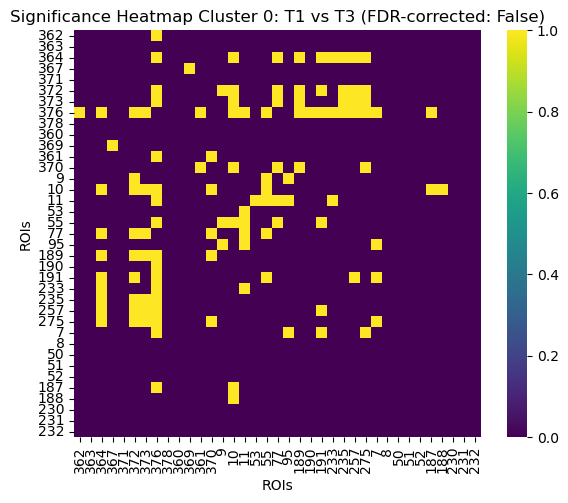


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (29, 37, 37)
Cluster 1 - Shape of T3 matrices: (29, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


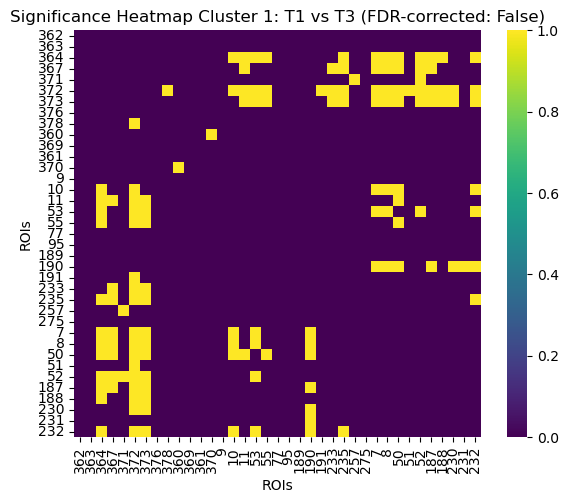

In [ ]:
results = functions.get_sig_matrix(t1_t3_matched, rois, correction=False, alpha=0.05, cluster=True)


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (20, 37, 37)
Cluster 0 - Shape of T3 matrices: (20, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


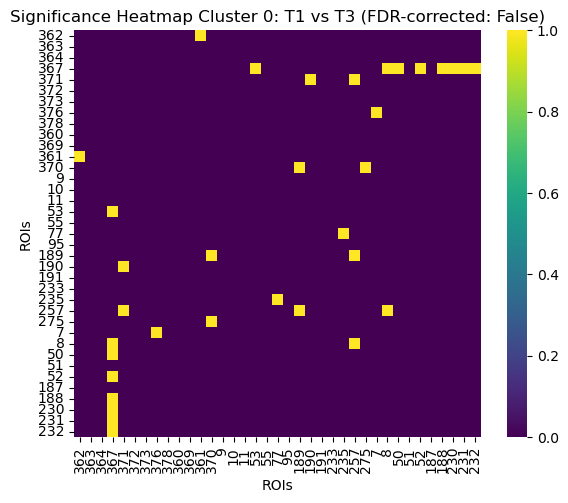


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (19, 37, 37)
Cluster 1 - Shape of T3 matrices: (19, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


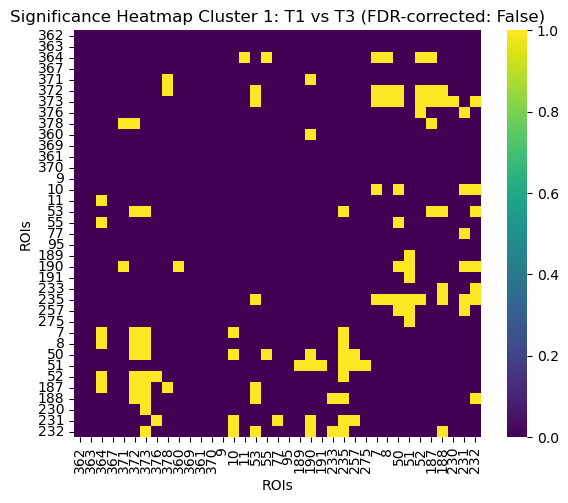

In [ ]:
results = functions.get_sig_matrix(t1_t3_matrices_labeled, rois, correction=False, alpha=0.05, cluster=True)

### Beginning of statistical testing


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (19, 37, 37)
Cluster 0 - Shape of T4 matrices: (19, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


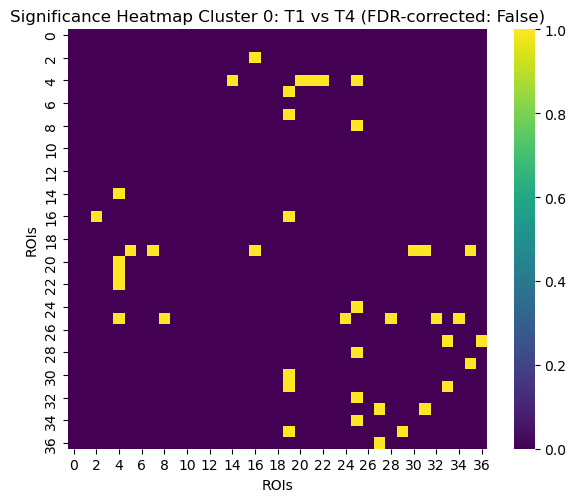


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (17, 37, 37)
Cluster 1 - Shape of T4 matrices: (17, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


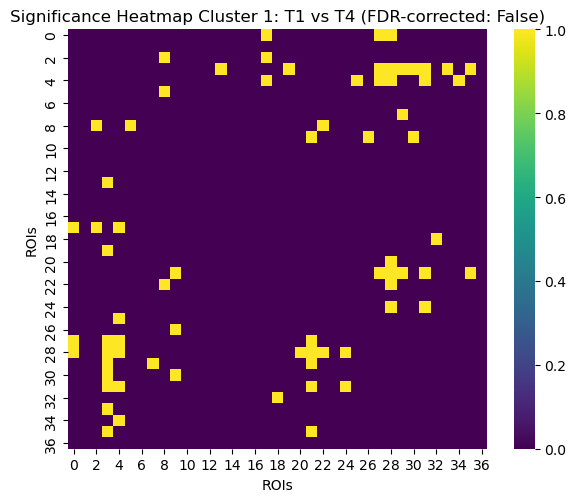

In [ ]:
results = get_sig_matrix(t1_t4_matrices_labeled, tp=4, correction=False, alpha=0.05, cluster=True)

Shape of T1 matrices: (65, 37, 37)
Shape of T3 matrices: (44, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


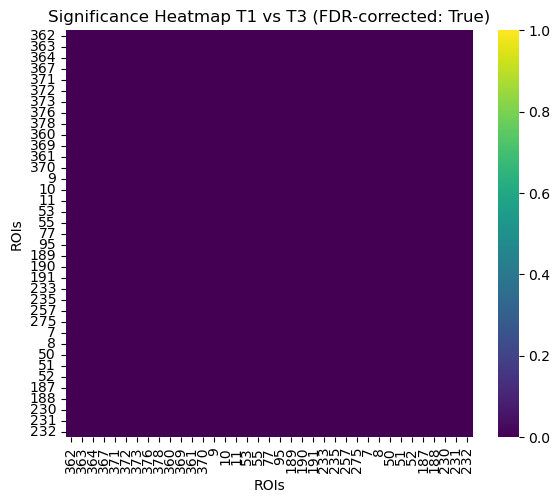

Shape of T1 matrices: (65, 37, 37)
Shape of T3 matrices: (44, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


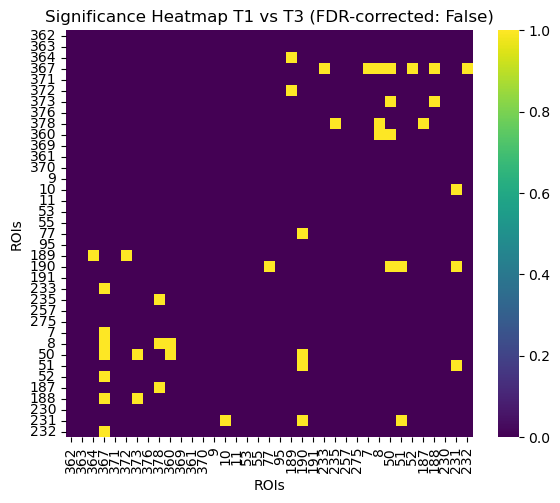


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (19, 37, 37)
Cluster 0 - Shape of T4 matrices: (19, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


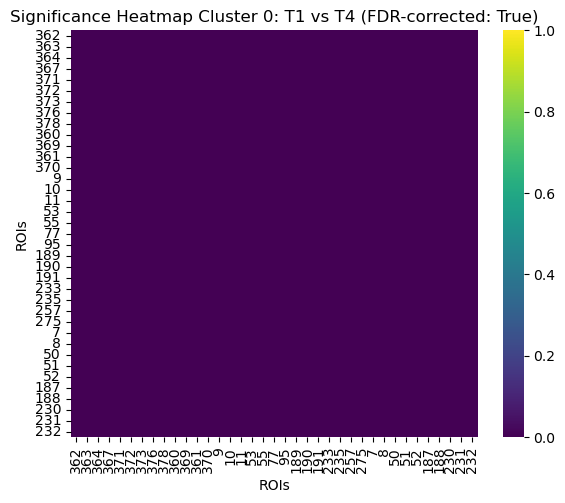


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (17, 37, 37)
Cluster 1 - Shape of T4 matrices: (17, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


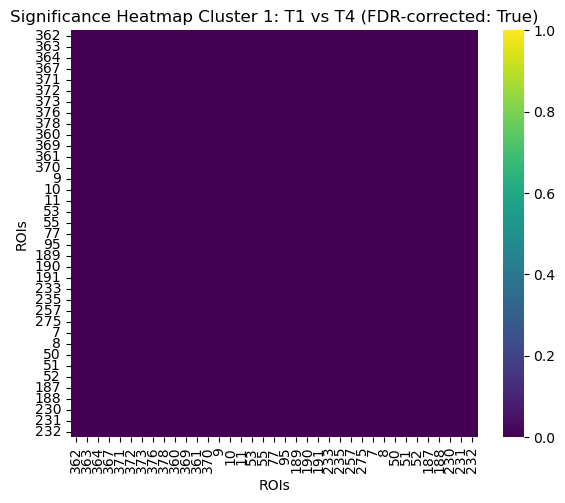


Analyzing Cluster 0...
Cluster 0 - Shape of T1 matrices: (19, 37, 37)
Cluster 0 - Shape of T4 matrices: (19, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


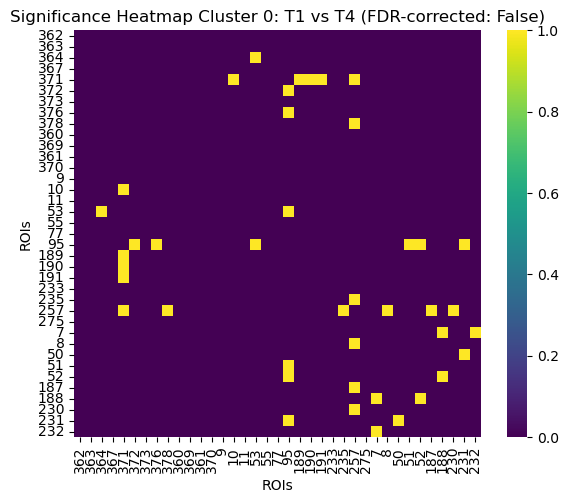


Analyzing Cluster 1...
Cluster 1 - Shape of T1 matrices: (17, 37, 37)
Cluster 1 - Shape of T4 matrices: (17, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


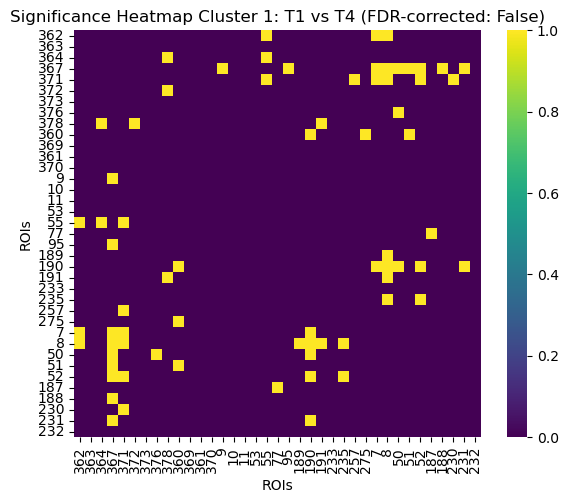

Shape of T1 matrices: (65, 37, 37)
Shape of T4 matrices: (42, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


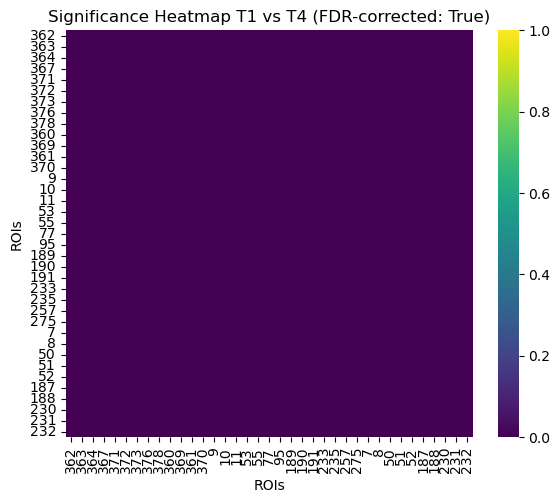

Shape of T1 matrices: (65, 37, 37)
Shape of T4 matrices: (42, 37, 37)


/Users/maylismuller/opt/anaconda3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


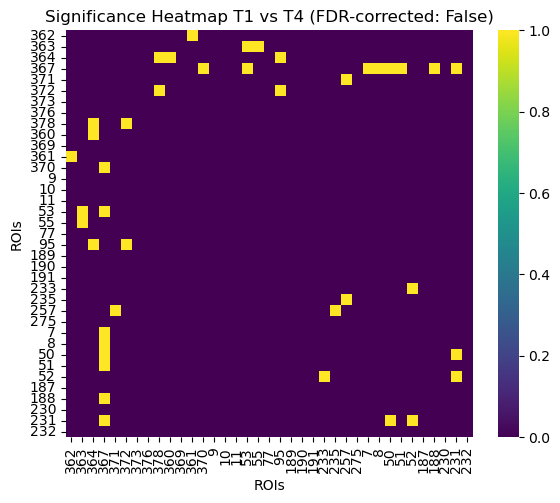

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[       nan, 0.25551029, 0.4015783 , ..., 0.64122593, 0.62244395,
         0.34159699],
        [0.25551029,        nan, 0.52060866, ..., 0.34481731, 0.26292186,
         0.87332444],
        [0.4015783 , 0.52060866,        nan, ..., 0.16426855, 0.37499409,
         0.09500018],
        ...,
        [0.64122593, 0.34481731, 0.16426855, ...,        nan, 0.55472845,
         0.6415112 ],
        [0.62244395, 0.26292186, 0.37499409, ..., 0.55472845,        nan,
         0.50564467],
        [0.34159699, 0.87332444, 0.09500018, ..., 0.6415112 , 0.50564467,
                nan]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [Fal

In [ ]:
get_sig_matrix(t1_t3_matrices, rois, tp=3, correction=True, alpha=0.05, cluster=False)
get_sig_matrix(t1_t3_matrices, rois, tp=3, correction=False, alpha=0.05, cluster=False)
get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=True, alpha=0.05, cluster=True)
get_sig_matrix(t1_t4_matrices_labeled, rois, tp=4, correction=False, alpha=0.05, cluster=True)
get_sig_matrix(t1_t4_matrices, rois, tp=4, correction=True, alpha=0.05, cluster=False)
get_sig_matrix(t1_t4_matrices, rois, tp=4, correction=False, alpha=0.05, cluster=False)

#### Code to do it by cluster for both T3 and T4

In [ ]:
functions.sig_matrix_T1_T(t1_t4_matrices_labeled, rois, tp = 4, alpha=0.05, cluster = True)

In [ ]:
functions.sig_matrix_T1_T(t1_t3_matrices_labeled, rois, tp = 3, alpha=0.05, cluster = True)

In [ ]:
t1_t3_matrices_labeled = functions.cluster_and_plot(t1_t3_matrices, numerical_cols_names= numerical_cols, categorical_cols_name=categorical_cols, clusters=2)
functions.compare_T1_T_by_cluster(t1_t3_matrices_labeled, rois, tp = 3, alpha=0.05, cluster = True)

### Look at difference between FC

In [ ]:
functions.compute_FC_diff(t1_t3_matrices_labeled, tp = 3)

### Regression Analysis